# Author prediction

Given an text excerpt from one of six authors, predict the author.

In [1]:
import warnings
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import urllib.request
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
sns.set_theme(style='whitegrid', context='notebook')
plt.rcParams['figure.figsize'] = 3,3

In [3]:
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
raw_data_dir = pathlib.Path("C:/Users/Glenn/Google Drive/CSUMB/courses/CST463-adv-machine-learning/datasets/gutenberg-books/")

In [5]:
train_dir = raw_data_dir / 'book_excerpts' / 'train'
test_dir = raw_data_dir / 'book_excerpts' / 'test'

#### Test to see that the files can be read

In [6]:
batch_size = 32
train_ds = keras.utils.text_dataset_from_directory(train_dir, batch_size=batch_size)

Found 17968 files belonging to 8 classes.


In [7]:
batch_size = 32
test_ds = keras.utils.text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 5989 files belonging to 8 classes.


In [8]:
# pairs in train_ds are (string, author_id)
for inputs, targets in train_ds:
    print(inputs.shape, inputs.dtype)
    print(targets.shape, targets.dtype)
    print(inputs[0])
    print(targets[0])
    break

(32,) <dtype: 'string'>
(32,) <dtype: 'int32'>
tf.Tensor(b'try it,\xe2\x80\x9d said Name, who liked new experiments. Miss Name and Mr. Name, Name, and Ned declined, but Name, Sallie, Name, and Name piled and drew, and the lot fell to Name. \xe2\x80\x9cWho are your heroes?\xe2\x80\x9d asked Name. \xe2\x80\x9cGrandfather and Napoleon.\xe2\x80\x9d \xe2\x80\x9cWhich lady here do you think prettiest?\xe2\x80\x9d said Sallie. \xe2\x80\x9cMargaret.\xe2\x80\x9d \xe2\x80\x9cWhich do you like best?\xe2\x80\x9d from Name. \xe2\x80\x9cName, of course.\xe2\x80\x9d \xe2\x80\x9cWhat silly questions you ask!\xe2\x80\x9d And Name gave a', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)


## Bag of words approach

The code in this section is mostly copied from Chollet's book.

Create a text vectorization layer

In [9]:
num_classes = 8
max_tokens = 20000

Simple multi-hot encoding.

In [10]:
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='multi_hot'
)

In [11]:
# text excerpt only - no author ID
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

In [12]:
binary_1gram_train_ds = train_ds.map(lambda x,y: (text_vectorization(x), y),
                                   num_parallel_calls=16)
binary_1gram_test_ds  = test_ds.map(lambda x,y: (text_vectorization(x), y),
                                  num_parallel_calls=16)

In [13]:
# sanity check
for inputs, targets in binary_1gram_train_ds:
    print(inputs.shape, inputs.dtype)
    print(targets.shape, targets.dtype)
    print(inputs[0])
    print(targets[0])
    break

(32, 20000) <dtype: 'float32'>
(32,) <dtype: 'int32'>
tf.Tensor([0. 1. 0. ... 0. 0. 0.], shape=(20000,), dtype=float32)
tf.Tensor(1, shape=(), dtype=int32)


2-grams

In [14]:
text_vectorization = layers.TextVectorization(
    ngrams=2,
    max_tokens=max_tokens,
    output_mode='multi_hot'
)

In [15]:
text_vectorization.adapt(text_only_train_ds)

In [16]:
binary_2gram_train_ds = train_ds.map(lambda x,y: (text_vectorization(x), y),
                                   num_parallel_calls=16)
binary_2gram_test_ds  = test_ds.map(lambda x,y: (text_vectorization(x), y),
                                  num_parallel_calls=16)

#### Simple feedforward model

In [17]:
def get_model(max_tokens=max_tokens, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    return model

In [18]:
K.clear_session()

In [19]:
model = get_model(hidden_dim=16)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
Total params: 320,152
Trainable params: 320,152
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [22]:
early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

It doesn't seem strange that a bag-of-words model works well.  It may be that the easiest way to distinguish these authors is by their choice of words, as opposed to the way that they form sentences.

In [23]:
history = model.fit(binary_2gram_train_ds.cache(),
                    validation_data=binary_2gram_test_ds.cache(),
                    epochs=50,
                    callbacks=[early_stopping]
                   )

Epoch 1/50
562/562 [==============================] - 5s 7ms/step - loss: 1.2535 - accuracy: 0.5687 - val_loss: 0.7732 - val_accuracy: 0.8170
Epoch 2/50
562/562 [==============================] - 2s 3ms/step - loss: 0.6628 - accuracy: 0.7677 - val_loss: 0.5237 - val_accuracy: 0.8544
Epoch 3/50
562/562 [==============================] - 1s 2ms/step - loss: 0.4850 - accuracy: 0.8254 - val_loss: 0.4438 - val_accuracy: 0.8616
Epoch 4/50
562/562 [==============================] - 1s 2ms/step - loss: 0.4099 - accuracy: 0.8468 - val_loss: 0.4193 - val_accuracy: 0.8639
Epoch 5/50
562/562 [==============================] - 1s 2ms/step - loss: 0.3655 - accuracy: 0.8603 - val_loss: 0.4136 - val_accuracy: 0.8624
Epoch 6/50
562/562 [==============================] - 1s 2ms/step - loss: 0.3440 - accuracy: 0.8699 - val_loss: 0.4102 - val_accuracy: 0.8656
Epoch 7/50
562/562 [==============================] - 1s 2ms/step - loss: 0.3349 - accuracy: 0.8713 - val_loss: 0.4111 - val_accuracy: 0.8644
Epoch 

## Sequential approach

In [29]:
max_tokens = 20000
max_length=35

text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=max_length
)

In [30]:
# pairs in int_train_ds are (token index sequence, author)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(lambda x,y: (text_vectorization(x), y), num_parallel_calls=16)
int_test_ds  = test_ds.map(lambda x,y: (text_vectorization(x), y), num_parallel_calls=16)

A bidirectional LSTM model with a one-hot or custom embedding layer.

In [242]:
def get_seq_model(max_tokens=max_tokens, embedding_dim=16, recurrent_layers=[16]):
    # input is a sequence of ints, of unknown length
    inputs = keras.Input(shape=(None,), dtype="int64") 
    if embedding_dim > 0:
        # custom embedding
        x = layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True)(inputs)
    else:
        # simple one-hot encoding
        x = tf.one_hot(inputs, depth=max_tokens)
    
    for i, num_cells in enumerate(recurrent_layers):
        return_sequences = (i < len(recurrent_layers) - 1)
        x = layers.LSTM(num_cells, return_sequences=return_sequences)(x)
            
    x = layers.Dropout(0.5)(x) 
    outputs = layers.Dense(num_classes, activation="relu")(x)
    model = keras.Model(inputs, outputs)
    return model

The model appears to be very sensitive to the embedding size, and number of recurrent cells.

In [68]:
class StopIfNotLearning(keras.callbacks.Callback):
    
    """ Stop training immediately if validation accuracy is too low. """
    
    def __init__(self, threshold):
        self.threshold = threshold
        
    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get('val_accuracy')
        if epoch == 0 and val_acc < self.threshold:
            self.model.stop_training = True
            print('Stopping because model not learning.')

In [69]:
stop_if_not_learning = StopIfNotLearning(0.126)

In [173]:
def test_model(params):
    """ Perform a grid search. """
    
    print(params)
    embedding_dim = params.get('embedding_dim', 16)
    recurrent_layers = params.get('recurrent_layers', [16])
    
    K.clear_session()
    model = get_seq_model(embedding_dim=embedding_dim, recurrent_layers=recurrent_layers)
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   
    history = model.fit(int_train_ds.cache(),
                        validation_data=int_test_ds.cache(),
                        epochs=4,
                        callbacks=[early_stopping, stop_if_not_learning]
                       )
    return history

In [225]:
param_grid = {'embedding_dim': [24,32,48], 'recurrent_layers': [[16, 16], [16, 16, 16], [16, 16, 16, 16]]}
results = []
for params in ParameterGrid(param_grid):
    history = test_model(params)
    test_results = params.copy()
    test_results['best_accuracy'] = max(history.history['val_accuracy'])
    results.append(test_results)
    
results_df = pd.DataFrame(results)

{'embedding_dim': 24, 'recurrent_layers': [16, 16]}
Epoch 1/4
562/562 [==============================] - 13s 17ms/step - loss: 2.2900 - accuracy: 0.3005 - val_loss: 1.5858 - val_accuracy: 0.4732
Epoch 2/4
562/562 [==============================] - 6s 10ms/step - loss: 1.6061 - accuracy: 0.5324 - val_loss: 1.6887 - val_accuracy: 0.5709
Epoch 3/4
562/562 [==============================] - 5s 10ms/step - loss: 1.4943 - accuracy: 0.6243 - val_loss: 2.1091 - val_accuracy: 0.5647
Epoch 4/4
562/562 [==============================] - 5s 10ms/step - loss: 1.8511 - accuracy: 0.5639 - val_loss: 1.8885 - val_accuracy: 0.2192
{'embedding_dim': 24, 'recurrent_layers': [16, 16, 16]}
Epoch 1/4
562/562 [==============================] - 17s 22ms/step - loss: 2.1970 - accuracy: 0.2862 - val_loss: 1.6842 - val_accuracy: 0.5043
Epoch 2/4
562/562 [==============================] - 8s 14ms/step - loss: 1.6445 - accuracy: 0.5142 - val_loss: 1.8008 - val_accuracy: 0.5460
Epoch 3/4
562/562 [===================

In [226]:
print(results_df)

   embedding_dim  recurrent_layers  best_accuracy
0             24          [16, 16]       0.570880
1             24      [16, 16, 16]       0.567207
2             24  [16, 16, 16, 16]       0.125230
3             32          [16, 16]       0.125230
4             32      [16, 16, 16]       0.601269
5             32  [16, 16, 16, 16]       0.566706
6             48          [16, 16]       0.605276
7             48      [16, 16, 16]       0.125230
8             48  [16, 16, 16, 16]       0.496577


In [227]:
if all_results is None:
    all_results = []
all_results.append(results_df)

In [228]:
all_results_df = pd.concat(all_results)
print(all_results_df.sort_values(by='best_accuracy', ascending=False))

   embedding_dim  recurrent_layers  best_accuracy
6             48          [16, 16]       0.605276
4             32      [16, 16, 16]       0.601269
1             32          [16, 16]       0.578728
4             12              [16]       0.577225
0             24          [16, 16]       0.570880
1             24      [16, 16, 16]       0.567207
2             32      [16, 16, 16]       0.566706
5             32  [16, 16, 16, 16]       0.566706
2              8      [16, 16, 16]       0.565704
1             64          [16, 16]       0.564034
1              8          [16, 16]       0.563533
5             16      [16, 16, 16]       0.563199
5             12          [16, 16]       0.559192
2             12      [16, 16, 16]       0.545834
3              8          [32, 32]       0.544498
0             32              [16]       0.527634
2             12              [16]       0.517783
8             48  [16, 16, 16, 16]       0.496577
3             10            [8, 8]       0.496410


It appears that an embedding dimension of 32 works pretty well, on average.

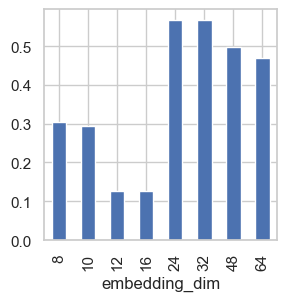

In [229]:
all_results_df.groupby('embedding_dim')['best_accuracy'].median().plot.bar();

32 is also best for variance.

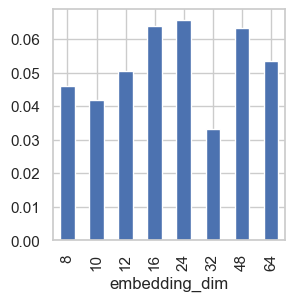

In [239]:
all_results_df.groupby('embedding_dim')['best_accuracy'].var().plot.bar();

It appears that three recurrent layers work best, on average.

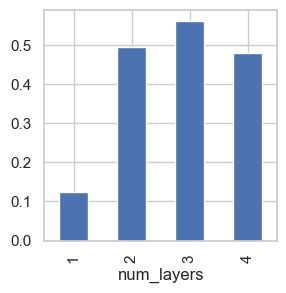

In [231]:
temp = all_results_df.copy()
temp['num_layers'] = all_results_df['recurrent_layers'].apply(len).values
temp.groupby('num_layers')['best_accuracy'].median().plot.bar();

3 layers is also best for variance.

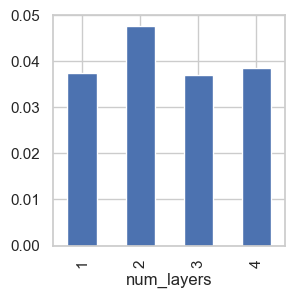

In [237]:
temp.groupby('num_layers')['best_accuracy'].var().plot.bar();

It appears that 16 recurrent cells works best.

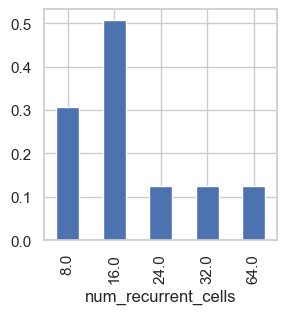

In [233]:
temp['num_recurrent_cells'] = all_results_df['recurrent_layers'].apply(np.mean)
temp.groupby('num_recurrent_cells')['best_accuracy'].median().plot.bar();

16 recurrent cells is also best for variance.

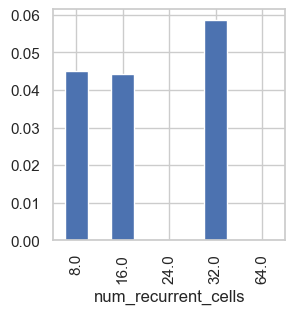

In [236]:
temp.groupby('num_recurrent_cells')['best_accuracy'].var().plot.bar();

A good model, on average.

In [255]:
K.clear_session()
model = get_seq_model(embedding_dim=32, recurrent_layers=[16, 16, 16])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 32)          640000    
                                                                 
 lstm (LSTM)                 (None, None, 16)          3136      
                                                                 
 lstm_1 (LSTM)               (None, None, 16)          2112      
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136   

Adam and nadam also seem to work okay.  It's possible that there is less variance when using adam or nadam.

In [256]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [257]:
history = model.fit(int_train_ds.cache(),
                    validation_data=int_test_ds.cache(),
                    epochs=50,
                    callbacks=[early_stopping]
                   )

Epoch 1/50
562/562 [==============================] - 17s 21ms/step - loss: 2.1424 - accuracy: 0.2985 - val_loss: 2.0521 - val_accuracy: 0.3934
Epoch 2/50
562/562 [==============================] - 7s 13ms/step - loss: 1.6592 - accuracy: 0.4903 - val_loss: 2.1407 - val_accuracy: 0.5026
Epoch 3/50
562/562 [==============================] - 7s 13ms/step - loss: 1.5913 - accuracy: 0.5789 - val_loss: 2.1396 - val_accuracy: 0.5468
Epoch 4/50
562/562 [==============================] - 7s 13ms/step - loss: 1.5342 - accuracy: 0.6259 - val_loss: 3.3574 - val_accuracy: 0.5356


### Pretrained (GloVe) embeddings

In [24]:
glove_dir = pathlib.Path("C:/Users/Glenn/Google Drive/CSUMB/courses/CST463-adv-machine-learning/datasets/glove-word-embeddings/glove.6B")
path_to_glove_file = glove_dir / 'glove.6B.100d.txt'
embedding_dim = 100

This is from Chollet, but encoding='utf8' needed to avoid decoding error.

In [25]:
def load_glove_model(file):

    embeddings_index = {} 
    with open(path_to_glove_file, encoding='utf8') as f:  
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
    print(f"Found {len(embeddings_index)} word vectors.")
    
    return embeddings_index

In [26]:
embeddings_index = load_glove_model(path_to_glove_file)

Found 400000 word vectors.


In [27]:
# sanity check
embeddings_index['sanity']

array([-0.22472  , -0.90548  ,  1.0144   , -0.207    , -0.26524  ,
        0.78904  , -0.41476  , -0.14425  , -0.23075  , -0.042493 ,
       -0.066621 ,  1.3307   , -0.33281  , -0.40447  , -0.55741  ,
       -0.14433  ,  0.22452  ,  0.61918  ,  0.032019 ,  0.18422  ,
        0.12759  , -0.78489  , -0.19454  , -0.74448  ,  0.48331  ,
        0.40592  ,  0.053454 , -0.90999  , -0.24271  , -0.50398  ,
        0.34459  , -0.1695   , -0.73323  ,  0.18242  , -0.20539  ,
        0.082089 , -0.25114  ,  0.33606  ,  0.32689  , -1.0689   ,
       -0.38783  , -0.32596  ,  0.25779  , -0.34238  , -0.27072  ,
       -0.49146  ,  0.3841   ,  0.030122 ,  0.2652   , -0.59712  ,
       -0.015908 , -0.44596  , -0.33581  ,  0.76121  ,  0.5341   ,
       -0.16729  ,  0.69395  , -0.64835  , -0.1194   ,  0.13988  ,
        0.49166  ,  0.1156   , -0.21935  , -0.25856  ,  0.0052909,
        0.55318  ,  0.076623 , -0.80822  ,  0.38003  , -0.33819  ,
        0.23787  ,  0.94368  ,  0.017491 , -0.26324  ,  0.1677

#### Build a word embedding matrix

I was getting a unicode decode error on the following statement.

Apparently there is a bug with certain versions of TensorFlow and Python on Windows.
A workaround is to change the default character encoding on Windows.

https://github.com/tensorflow/tensorflow/issues/43559

https://scholarslab.github.io/learn-twarc/08-win-region-settings

Changing the default encoding worked for me.

In [31]:
vocabulary = text_vectorization.get_vocabulary()

In [33]:
word_index = dict(zip(vocabulary, range(len(vocabulary))))  # maps words to token indexes
embedding_matrix = np.zeros((max_tokens, embedding_dim))    # embedding_matrix[i] is embedding for token index i
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [37]:
# sanity check
print(word_index['sanity'])
embedding_matrix[8015]

8015


array([-0.22472   , -0.90548003,  1.01440001, -0.207     , -0.26524001,
        0.78904003, -0.41475999, -0.14425001, -0.23074999, -0.042493  ,
       -0.066621  ,  1.33070004, -0.33281001, -0.40447   , -0.55741   ,
       -0.14432999,  0.22452   ,  0.61918002,  0.032019  ,  0.18422   ,
        0.12759   , -0.78489   , -0.19453999, -0.74448001,  0.48331001,
        0.40592   ,  0.053454  , -0.90999001, -0.24270999, -0.50397998,
        0.34459001, -0.16949999, -0.73322999,  0.18242   , -0.20539001,
        0.082089  , -0.25114   ,  0.33605999,  0.32688999, -1.06889999,
       -0.38782999, -0.32596001,  0.25779   , -0.34237999, -0.27072001,
       -0.49146   ,  0.38409999,  0.030122  ,  0.26519999, -0.59711999,
       -0.015908  , -0.44595999, -0.33581001,  0.76121002,  0.5341    ,
       -0.16729   ,  0.69395   , -0.64835   , -0.1194    ,  0.13988   ,
        0.49166   ,  0.1156    , -0.21935   , -0.25856   ,  0.0052909 ,
        0.55317998,  0.076623  , -0.80822003,  0.38003001, -0.33

#### load GloVe embeddings into a embedding layer

In [40]:
embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), 
    trainable=False, 
    mask_zero=True
)

#### a model that uses the embedding layer

In [41]:
def get_model_with_pretrained_emb(recurrent_layers=[16]):
    # input is a sequence of ints, of unknown length
    inputs = keras.Input(shape=(None,), dtype="int64") 
    x = embedding_layer(inputs)
    
    for i, num_cells in enumerate(recurrent_layers):
        return_sequences = (i < len(recurrent_layers) - 1)
        x = layers.LSTM(num_cells, return_sequences=return_sequences)(x)
            
    x = layers.Dropout(0.5)(x) 
    outputs = layers.Dense(num_classes, activation="relu")(x)
    model = keras.Model(inputs, outputs)
    return model

In [79]:
K.clear_session()
model = get_model_with_pretrained_emb(recurrent_layers=[32, 32, 32])
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])   

In [80]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 lstm (LSTM)                 (None, None, 32)          17024     
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264   

This model, like the early model with learned embeddings, seems to have problems learning.

When it trains, it reaches accuracy values similar to the model with the learned embedding layer: about 55% validation accuracy.

In [81]:
early_stopping = EarlyStopping(patience=6, restore_best_weights=True)

In [82]:
history = model.fit(int_train_ds.cache(),
                    validation_data=int_test_ds.cache(),
                    epochs=50,
                    callbacks=[early_stopping, stop_if_not_learning]
                    )

Epoch 1/50
562/562 [==============================] - 17s 23ms/step - loss: 3.9135 - accuracy: 0.1252 - val_loss: 2.0794 - val_accuracy: 0.1252
